<a href="https://colab.research.google.com/github/Ana-dg/Loan-Risk-Prediction/blob/main/Big_Data_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [ ]:
# Install PySpark
!pip install pyspark

In [ ]:
import zipfile
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, isnull, expr, create_map,lit
from itertools import chain
from pyspark.sql.functions import lag, to_date, unix_timestamp, from_unixtime
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml import Pipeline
from pyspark.sql.functions import sqrt, array
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("TestApp")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:

zip_path = '/content/drive/MyDrive/Loan_dataset.zip'
extract_to = '/content/drive/MyDrive/Loan_dataset'
os.makedirs(extract_to, exist_ok=True)


 #with zipfile.ZipFile(zip_path, 'r') as zip_ref:
     #zip_ref.extractall(extract_to)

extracted_files = os.listdir(extract_to)
print("Extracted files:", extracted_files)


In [ ]:
accepted_df = spark.read.csv('/content/drive/MyDrive/Loan_dataset/accepted_2007_to_2018q4.csv', header=True, inferSchema=True)

accepted_df.printSchema()


root
 |-- id: integer (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double

Analyze dataset csv

In [ ]:
accepted_df.show()

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-

Data Cleaning

Delete irrelevant columns

In [ ]:
columns_to_drop = [
    'member_id', 'funded_amnt', 'funded_amnt_inv', 'verification_status',
    'pymnt_plan', 'url', 'desc', 'zip_code', 'earliest_cr_line', 'last_pymnt_d',
    'next_pymnt_d', 'last_credit_tull_d', 'verification_status_joint','debt_settlement_flag_date','initial_list_status',
    'revol_bal_joint', "last_credit_pull_d", "application_type", "sec_app_fico_range_low", "sec_app_fico_range_high",
    "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc",
    "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts",
    "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med",
    "sec_app_mths_since_last_major_derog", "hardship_flag", "hardship_type", "hardship_reason",
    "hardship_status", "hardship_start_date", "hardship_end_date", "payment_plan_start_date",
    "hardship_loan_status", "disbursement_method", "debt_settlement_flag", "settlement_status",
    "settlement_date","num_tl_120dpd_2m","addr_state","purpose",'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl','mths_since_recent_bc','mths_since_last_delinq','mths_since_recent_inq'
]

df = accepted_df.drop(*columns_to_drop)
df.show()


+--------+---------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+--------+-----------+--------------------+-----+-----------+--------------+---------------+--------------+----------------------+--------+-------+---------+----------+---------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+---------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+--------------------+-----------+--------------+-------+------------------------+-----------+--------+------------------------+------------------------------+---------------------+--

Size of the df:

In [ ]:
num_rows = df.count()
num_columns = len(df.columns)
print(f"The DataFrame has {num_rows} rows and {num_columns} columns.")


The DataFrame has 70052 rows and 100 columns.


Handle missing data

In [ ]:
missing_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0]
for col_name in df.columns:
    missing_count = missing_counts[col_name]
    if missing_count > 0:
        print(f"Column '{col_name}' has {missing_count} missing values.")


Column 'emp_title' has 4272 missing values.
Column 'emp_length' has 4262 missing values.
Column 'title' has 132 missing values.
Column 'dti' has 2 missing values.
Column 'mths_since_last_record' has 57248 missing values.
Column 'revol_util' has 31 missing values.
Column 'mths_since_last_major_derog' has 49391 missing values.
Column 'annual_inc_joint' has 69695 missing values.
Column 'dti_joint' has 69697 missing values.
Column 'open_acc_6m' has 48680 missing values.
Column 'open_act_il' has 48680 missing values.
Column 'open_il_12m' has 48680 missing values.
Column 'open_il_24m' has 48680 missing values.
Column 'mths_since_rcnt_il' has 49242 missing values.
Column 'total_bal_il' has 48680 missing values.
Column 'il_util' has 51435 missing values.
Column 'open_rv_12m' has 48680 missing values.
Column 'open_rv_24m' has 48680 missing values.
Column 'max_bal_bc' has 48680 missing values.
Column 'all_util' has 48680 missing values.
Column 'total_rev_hi_lim' has 1 missing values.
Column 'inq

Delete the columns that have more than 40000 missing values

In [ ]:
drop_null_columns = [column for column in df.columns if df.filter(df[column].isNull()).count() > 40000]
df = df.drop(*drop_null_columns)
print("Dropped columns:", drop_null_columns)

Dropped columns: ['mths_since_last_record', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'deferral_term', 'hardship_amount', 'hardship_length', 'hardship_dpd', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'settlement_amount', 'settlement_percentage', 'settlement_term']


Replace the categorical variables with the most frequent terms

In [ ]:
string_columns = [column for column, dtype in df.dtypes if dtype == 'string']
for column in string_columns:
    field = df.schema[column]
    print(f"Column: {field.name}, Type: {field.dataType}")

Column: term, Type: StringType()
Column: grade, Type: StringType()
Column: sub_grade, Type: StringType()
Column: emp_title, Type: StringType()
Column: emp_length, Type: StringType()
Column: home_ownership, Type: StringType()
Column: issue_d, Type: StringType()
Column: loan_status, Type: StringType()
Column: title, Type: StringType()


In [ ]:
spark = SparkSession.builder.appName("FillMissingValues").getOrCreate()

columns_to_fill = ["sub_grade", "emp_title", "emp_length", "home_ownership",
                   "title"]

def get_most_frequent_value(df, col_name):
    mode_row = df.groupBy(col_name).count().filter(col(col_name).isNotNull()).orderBy('count', descending=True).first()
    return mode_row[col_name] if mode_row is not None else None

try:
    for col_name in columns_to_fill:
        if col_name in df.columns:
            mode_value = get_most_frequent_value(df, col_name)
            if mode_value is not None:
                df = df.na.fill({col_name: mode_value})
            else:
                print(f"No valid mode (non-null) found for {col_name}; column not filled.")
        else:
            print(f"Column {col_name} does not exist in DataFrame.")
except Exception as e:
    print(f"An error occurred: {e}")

df.show()


+--------+---------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+--------+-----------+--------------------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+-----------+--------------+------------+-----------+----------------+--------------------+-----------+--------------+-------+------------------------+-----------+--------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+-----------------

Remove duplicates

In [ ]:
df = df.dropDuplicates()
print("Number of rows after removing duplicates:", df.count())

Number of rows after removing duplicates: 70052


Ensure dtypes are ok: Transformed column "issue_d" to be date type

In [ ]:
df = df.withColumn("issue_d", to_date(unix_timestamp(col("issue_d"), "MMM-yyyy").cast("timestamp")))

# One-Hot Encoding

One hot encoding for target variable

In [ ]:
unique_loan_statuses = df.select("loan_status").distinct()
unique_loan_statuses.show()

+------------------+
|       loan_status|
+------------------+
|        Fully Paid|
|           Default|
|   In Grace Period|
|       Charged Off|
|Late (31-120 days)|
|           Current|
| Late (16-30 days)|
+------------------+



In [ ]:
df_encoded = df.withColumn('target', when((df.loan_status == 'Fully Paid'), 1).otherwise(0))
df_encoded.show()

+--------+---------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+----------+------------------+--------------------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+-----------+--------------+------------+-----------+----------------+--------------------+-----------+--------------+-------+------------------------+-----------+--------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------

One hot for subgrade (this is a more detailed extension of the column "grade" )

In [ ]:
sub_grade_mapping = {
    'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
    'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35
}


mapping_expr = create_map([lit(x) for x in chain(*sub_grade_mapping.items())])
df_encoded = df_encoded.withColumn("sub_grade_index", mapping_expr[col("sub_grade")])
onehot_encoder = OneHotEncoder(inputCols=["sub_grade_index"], outputCols=["sub_grade_vec"])
pipeline = Pipeline(stages=[onehot_encoder])
model = pipeline.fit(df_encoded)
df_encoded = model.transform(df_encoded)
df_encoded.show()

+--------+---------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+----------+------------------+--------------------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+-----------+--------------+------------+-----------+----------------+--------------------+-----------+--------------+-------+------------------------+-----------+--------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------

In [ ]:
term_indexer = StringIndexer(inputCol="term", outputCol="term_index")
onehot_encoder = OneHotEncoder(inputCols=["term_index"], outputCols=["term_vec"])
pipeline = Pipeline(stages=[term_indexer, onehot_encoder])
model = pipeline.fit(df_encoded)
df_encoded = model.transform(df_encoded)
df_encoded.show()

+--------+---------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+----------+------------------+--------------------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+-----------+--------------+------------+-----------+----------------+--------------------+-----------+--------------+-------+------------------------+-----------+--------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------

In [ ]:
emp_length_indexer = StringIndexer(inputCol="emp_length", outputCol="emp_length_index")
onehot_encoder = OneHotEncoder(inputCols=["emp_length_index"], outputCols=["emp_length_vec"])
pipeline = Pipeline(stages=[emp_length_indexer, onehot_encoder])
model = pipeline.fit(df_encoded)
df_encoded = model.transform(df_encoded)
df_encoded.show()


+--------+---------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+----------+------------------+--------------------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+-----------+--------------+------------+-----------+----------------+--------------------+-----------+--------------+-------+------------------------+-----------+--------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------

In [ ]:
home_ownership_indexer = StringIndexer(inputCol="home_ownership", outputCol="home_ownership_index")
onehot_encoder = OneHotEncoder(inputCols=["home_ownership_index"], outputCols=["home_ownership_vec"])
pipeline = Pipeline(stages=[home_ownership_indexer, onehot_encoder])
model = pipeline.fit(df_encoded)
df_encoded = model.transform(df_encoded)
df_encoded.show()

+--------+---------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+----------+------------------+--------------------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+-----------+--------------+------------+-----------+----------------+--------------------+-----------+--------------+-------+------------------------+-----------+--------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------

In [ ]:
title_indexer = StringIndexer(inputCol="title", outputCol="title_index")
onehot_encoder = OneHotEncoder(inputCols=["title_index"], outputCols=["title_vec"])
pipeline = Pipeline(stages=[title_indexer, onehot_encoder])
model = pipeline.fit(df_encoded)
df_encoded = model.transform(df_encoded)
df_encoded.show()

+--------+---------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+----------+------------------+--------------------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+-----------+--------------+------------+-----------+----------------+--------------------+-----------+--------------+-------+------------------------+-----------+--------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------

Feature engineering



*   Income and Loan Amount Interaction: see if higher loans are proportionately riskier across different income brackets
*   Interest rate dti interaction: explore if borrowers with higher DTI are more affected by higher interest rates.



In [ ]:
spark = SparkSession.builder.appName("InteractionTerms").getOrCreate()

df_encoded = df_encoded.withColumn("income_loan_interaction", col("annual_inc") * col("loan_amnt"))

df_encoded = df_encoded.withColumn("int_rate_dti_interaction", col("int_rate") * col("dti"))

df_encoded.select("annual_inc", "loan_amnt", "income_loan_interaction",
          "int_rate", "dti", "int_rate_dti_interaction").show()


+----------+---------+-----------------------+--------+-----+------------------------+
|annual_inc|loan_amnt|income_loan_interaction|int_rate|  dti|int_rate_dti_interaction|
+----------+---------+-----------------------+--------+-----+------------------------+
|   35000.0|   4225.0|              1.47875E8|   14.85|15.22|                 226.017|
|   75000.0|  20000.0|                  1.5E9|   14.85|18.76|                 278.586|
|  118000.0|  28000.0|                3.304E9|   15.77|35.91|       566.3006999999999|
|   20000.0|   6950.0|                 1.39E8|   13.99|24.13|      337.57869999999997|
|   57774.0|  24000.0|             1.386576E9|   21.48|24.05|                 516.594|
|   40000.0|   8000.0|                  3.2E8|   11.48| 36.6|                 420.168|
|  108000.0|  32000.0|                3.456E9|   12.88|25.63|                330.1144|
|   47000.0|  15025.0|              7.06175E8|   25.09|11.54|                289.5386|
|   54500.0|  10000.0|                 5.45

Feature sampling on the accepted csv: LASSO

In [ ]:
numeric_columns = [column for column, dtype in df_encoded.dtypes if dtype =='double']

print("Numeric columns:", numeric_columns)

Numeric columns: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_li

Error because of the null values that have to be solved: either replace with 0, or with the mean

In [ ]:
exclude_columns = {'title_index', 'home_ownership_index', 'emp_length_index', 'term_index'}


missing_value_counts = [
    count(when(col(c).isNull() | isnan(c), c)).alias(c)
    for c in numeric_columns if c not in exclude_columns
]
missing_counts_df = df_encoded.agg(*missing_value_counts)
missing_counts_df.show(vertical=True)

-RECORD 0-------------------------
 loan_amnt                  | 0   
 int_rate                   | 0   
 installment                | 0   
 annual_inc                 | 0   
 dti                        | 2   
 delinq_2yrs                | 0   
 fico_range_low             | 0   
 fico_range_high            | 0   
 inq_last_6mths             | 0   
 open_acc                   | 0   
 pub_rec                    | 0   
 revol_bal                  | 0   
 revol_util                 | 31  
 total_acc                  | 0   
 out_prncp                  | 0   
 out_prncp_inv              | 0   
 total_pymnt                | 0   
 total_pymnt_inv            | 0   
 total_rec_prncp            | 0   
 total_rec_int              | 0   
 total_rec_late_fee         | 0   
 recoveries                 | 0   
 collection_recovery_fee    | 0   
 last_pymnt_amnt            | 0   
 last_fico_range_high       | 0   
 last_fico_range_low        | 0   
 collections_12_mths_ex_med | 0   
 policy_code        

*   For rows with more values, where the amounts are in dollars, we take the median values(bc_open_to_buy,bc_util)
*   We deleted the rows that have few missing values(like revol_util)
*   For the columns that have months as values(but have the double type we will have to treat them differently)
*   Delete the numerical columns with many missing values
*   For rows that have less than 3 missing values we delete them


In [ ]:
df_encoded = df_encoded.na.drop(subset=["revol_util"])
columns_to_fill = ["bc_open_to_buy", "bc_util","percent_bc_gt_75"]

medians = {}
for column in columns_to_fill:
    median_val = df_encoded.approxQuantile(column, [0.5], 0.25)[0]
    medians[column] = median_val
for column, median in medians.items():
    df_encoded = df_encoded.na.fill({column: median})
df_encoded.show()

In [ ]:
columns_and_types = df_encoded.dtypes
numeric_columns = [c for c, t in columns_and_types if t in ['double']]
missing_value_counts = []
for c, t in columns_and_types:
    if c in numeric_columns:
        condition = when(col(c).isNull() | isnan(col(c)), 1)
    else:
        condition = when(col(c).isNull(), 1)
    missing_value_counts.append(count(condition).alias(c))

missing_counts_df = df_encoded.agg(*missing_value_counts)
missing_counts = missing_counts_df.collect()[0].asDict()
columns_with_few_missing = [c for c, count in missing_counts.items() if count in [1, 2] and c != 'issue_d']
print("Columns with 1 or 2 missing values (excluding 'issue_d'):", columns_with_few_missing)


In [ ]:
df_encoded = df_encoded.dropna(subset=columns_with_few_missing)

Prepare the numeric data for feature sampling on numeric data(keep only the numeric data and exclude the string and date columns)

In [ ]:
numeric_columns = [column for column, dtype in df_encoded.dtypes if dtype == 'double']
df_numeric_data = df_encoded.select(*numeric_columns)
df_numeric_data=df_numeric_data.drop('termIndex','emp_lengthIndex','home_ownershipIndex','titleIndex')
df_numeric_data.show()

EDA

In [ ]:
df_for_eda=df_encoded.drop('home_ownership_vec','title_vec','sub_grade_vec','term_vec','emp_length_vec','termIndex','emp_lengthIndex','home_ownershipIndex','titleIndex')


Visualize the distribution of the target:

In [ ]:
label_counts = df_for_eda.groupBy('target').count()
label_counts_pd = label_counts.toPandas()
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.bar(label_counts_pd['target'], label_counts_pd['count'], color=['red', 'green'])
plt.xlabel('Target Label')
plt.ylabel('Count')
plt.title('Distribution of Target Labels')
plt.xticks(label_counts_pd['target'])
plt.show()

Point-biserial correlation analysis for continuous variables

In [ ]:
numeric_columns = [column for column, dtype in df_for_eda.dtypes if dtype == 'double']
df_corr = df_for_eda.select(['target'] + numeric_columns).toPandas()
correlation_results = []
for feature in numeric_columns:
    correlation, p_value = stats.pointbiserialr(df_corr['target'], df_corr[feature])
    correlation_results.append((feature, correlation, p_value))
results_df = pd.DataFrame(correlation_results, columns=['Feature', 'Correlation', 'P-value'])
print(results_df)



In [ ]:
significant_results = results_df[results_df['P-value'] < 0.05]
significant_results_sorted = significant_results.sort_values(by='P-value')
print("Significant Point-biserial correlation Results (p < 0.05):")
print(significant_results_sorted)

In [ ]:
key_features = [
    'out_prncp_inv', 'out_prncp', 'last_fico_range_high', 'last_fico_range_low',
    'last_pymnt_amnt', 'collection_recovery_fee', 'recoveries', 'total_rec_int',
    'total_rec_prncp', 'total_pymnt_inv', 'total_pymnt', 'int_rate_dti_interaction',
    'int_rate'
]

df_selected = df_for_eda.select(*key_features, 'target').toPandas()
for feature in key_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_selected, x=feature, hue='target', kde=True)
    plt.title(f'Histogram of {feature} by Loan Risk')
    plt.show()


**Chi square test**: sub_grade, home_ownership,title,term

In [ ]:
categorical_features = ['sub_grade', 'home_ownership', 'title', 'term']

for feature in categorical_features:
    assembler = VectorAssembler(inputCols=[feature + "_index"], outputCol="features")
    df_vector = assembler.transform(df_for_eda)
    r = ChiSquareTest.test(df_vector, "features", "target").head()
    print(f"Chi-square test for {feature} against Target")
    print("pValues: " + str(r.pValues))
    print("degreesOfFreedom: " + str(r.degreesOfFreedom))
    print("statistics: " + str(r.statistics))
    print("\n")


In [ ]:
chi_square_results = {
    'Sub Grade': 7989.3098,
    'Home Ownership': 57.4930,
    'Title': 243.3119,
    'Term': 15176.5029
}
features = list(chi_square_results.keys())
values = [chi_square_results[feature] for feature in features]

plt.figure(figsize=(10, 6))
plt.bar(features, values, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Chi-square Statistic')
plt.title('Chi-square Statistics of Categorical Features')
plt.xticks(rotation=45)
plt.show()


The distribution of the continuous data

In [ ]:
 for column in df_for_eda.select_dtypes(include=['double']):
     plt.figure(figsize=(10, 5))
     plt.hist(df_for_eda[column], bins=30, alpha=0.5, color='b')
     plt.title(f'Histogram of {column}')
     plt.xlabel(column)
     plt.ylabel('Frequency')
     plt.grid(True)
     plt.show()


Subset selection to keep the relevant features(we have a very large number of features). Using Correlation analysis and correlation based selection because PySpark doesnt have a stepwise selection built-in

To standardize the data(to preserve the distribution in case we have columns with different units($,%)

Using L2 Norm (standartization)

In [ ]:
numeric_features = [
    'out_prncp_inv', 'out_prncp', 'last_fico_range_high', 'last_fico_range_low',
    'last_pymnt_amnt', 'collection_recovery_fee', 'recoveries', 'total_rec_int',
    'total_rec_prncp', 'total_pymnt_inv', 'total_pymnt', 'int_rate_dti_interaction',
    'int_rate'
]
categorical_features = ['sub_grade', 'home_ownership', 'title', 'term']


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer(norm='l2'))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse_output=False)),
    ('normalizer', Normalizer(norm='l2'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


df_for_eda_pandas = df_for_eda.toPandas()
transformed_data = preprocessor.fit_transform(df_for_eda_pandas)

print(transformed_data)


## Dimensionality Reduction

PCA

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA()
pca.fit(transformed_data)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(
    [i + 1 for i in range(len(explained_variance))],
    np.cumsum(explained_variance),
    marker='o'
)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.xlabel('Individual Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Components')
plt.show()


As we can see, the number of components that are relevant are 20:
Since the elbow of the plot is around the fourth component, selecting four components would likely capture most of the significant variance(around 90% of the data) in the data while reducing dimensionality efficiently. This would keep the model simpler and more interpretable, without losing much information.

LDA

In [ ]:
categorical_features = ['sub_grade', 'home_ownership', 'title', 'term']
continuous_features = [
    'out_prncp_inv', 'out_prncp', 'last_fico_range_high', 'last_fico_range_low',
    'last_pymnt_amnt', 'collection_recovery_fee', 'recoveries', 'total_rec_int',
    'total_rec_prncp', 'total_pymnt_inv', 'total_pymnt', 'int_rate_dti_interaction',
    'int_rate'
]
target = 'target'
indexed_columns = [c + "_index" for c in categorical_features]

encoders = [
    OneHotEncoder(inputCols=[c], outputCols=[c.replace("_index", "_vec")]) for c in indexed_columns
]

assembler = VectorAssembler(
    inputCols=[c.replace("_index", "_vec") for c in indexed_columns] + continuous_features,
    outputCol="features"
)

pipeline = Pipeline(stages=encoders + [assembler])

df_lda = pipeline.fit(df_for_eda).transform(df_for_eda)


Applying min max scaling on the features

In [ ]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_lda)
df_scaled = scaler_model.transform(df_lda)

Using LDA

In [ ]:
df_lda = df_scaled.select("scaled_features", target).toPandas()
X = np.array(df_lda['scaled_features'].tolist())
y = df_lda[target]
lda = LDA(n_components=1)


TruncatedSVD

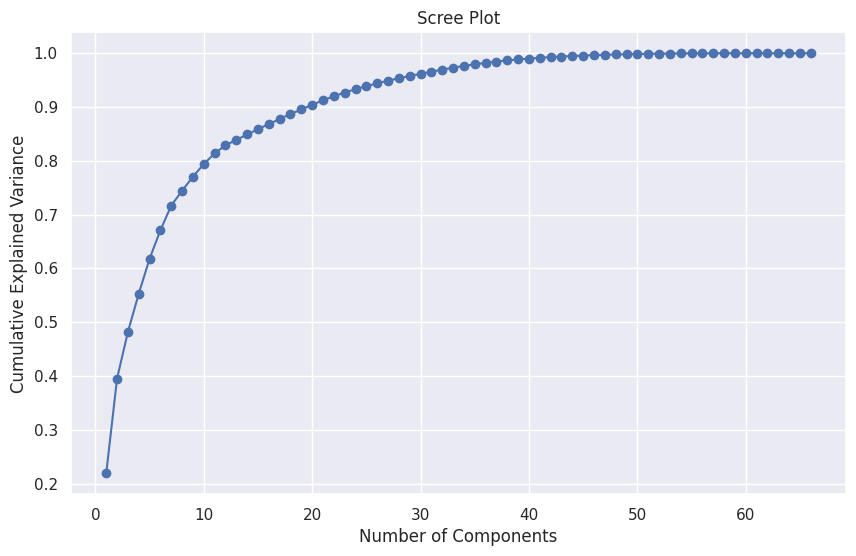

In [ ]:
svd = TruncatedSVD()
svd_data = svd.fit_transform(df_lda)

plt.figure(figsize=(10, 6))
plt.plot(
    [i + 1 for i in range(len(explained_variance))],
    np.cumsum(explained_variance),
    marker='o'
)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()


Models

Logistic Regression

In [ ]:
df_lda = df_scaled.select("scaled_features", target).toPandas()
X = np.array(df_lda['scaled_features'].tolist())
y = df_lda[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time_logistic_original = time.time()
logistic_model_original = LogisticRegression()
logistic_model_original.fit(X_train, y_train)
y_pred_original = logistic_model_original.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)
logistic_time_original = time.time() - start_time_logistic_original
print(f"Logistic Regression on Original Data Accuracy: {accuracy_original}")
print(f"Logistic Regression on Original Data time: {logistic_time_original:.4f} seconds")

Logistic Regression on Original Data Accuracy: 0.975078548986004
Logistic Regression on Original Data time: 1.1331 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics like accuracy, precision, recall, and F1-score

In [ ]:
accuracy = accuracy_score(y_test, y_pred_original)
precision = precision_score(y_test, y_pred_original)
recall = recall_score(y_test, y_pred_original)
f1 = f1_score(y_test, y_pred_original)
print("\nLogistic Regression:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Logistic Regression:
Accuracy: 0.9751
Precision: 0.9777
Recall: 0.9868
F1-score: 0.9823


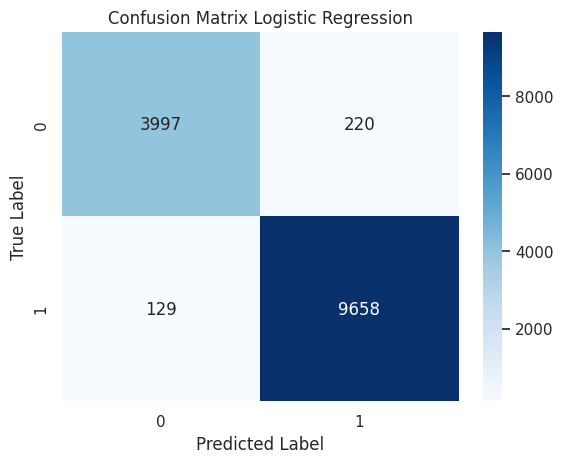

In [ ]:
cm = confusion_matrix(y_test, y_pred_original)
ax = sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix Logistic Regression')
plt.show()

Logistic Regression gridsearch

In [ ]:
param_grid = {
    'C': [100,1000,10000],
    'solver': ['liblinear', 'lbfgs']
}

start_time_grid_search = time.time()
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
grid_search_time = time.time() - start_time_grid_search

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_original = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_original)
print(f"Logistic Regression on LDA data (Grid Search) Accuracy: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"Grid Search for Logistic Regression time: {grid_search_time:.4f} seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression on LDA data (Grid Search) Accuracy: 0.9837903456155385
Best Parameters: {'C': 10000, 'solver': 'liblinear'}
Grid Search for Logistic Regression time: 51.0625 seconds


Metrics like accuracy, precision, recall, and F1-score

In [ ]:
accuracy_no_lda = accuracy_score(y_test, y_pred_original)
precision_no_lda = precision_score(y_test, y_pred_original)
recall_no_lda = recall_score(y_test, y_pred_original)
f1_no_lda = f1_score(y_test, y_pred_original)
print("\nLogistic Regression after gridsearch:")
print(f"Accuracy: {accuracy_no_lda:.4f}")
print(f"Precision: {precision_no_lda:.4f}")
print(f"Recall: {recall_no_lda:.4f}")
print(f"F1-score: {f1_no_lda:.4f}")


Logistic Regression after gridsearch:
Accuracy: 0.9838
Precision: 0.9838
Recall: 0.9932
F1-score: 0.9885


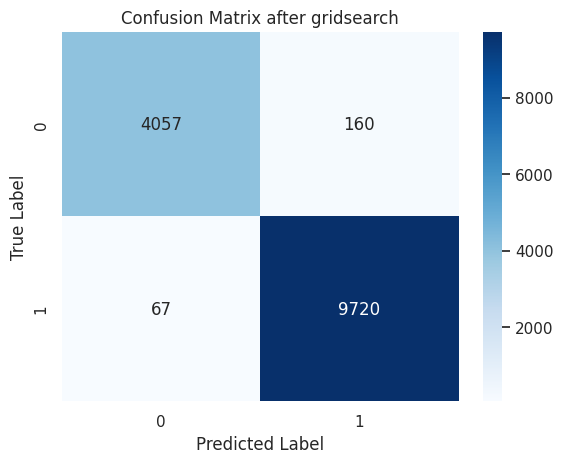

In [ ]:
cm = confusion_matrix(y_test, y_pred_original)
ax = sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix after gridsearch')
plt.show()

Logistic Regression trained on LDA data

In [ ]:
start_time_lda = time.time()
lda.fit(X_train, y_train)
lda_time = time.time() - start_time_lda
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
start_time_logistic = time.time()
logistic_model = LogisticRegression()
logistic_model.fit(X_train_lda, y_train)
logistic_time = time.time() - start_time_logistic
y_pred = logistic_model.predict(X_test_lda)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression on LDA data Accuracy: {accuracy}")
print(f"Logistic Regression computation time: {logistic_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression on LDA data Accuracy: 0.9626535275635533
LDA computation time: 1.5834 seconds
Logistic Regression computation time: 0.2031 seconds


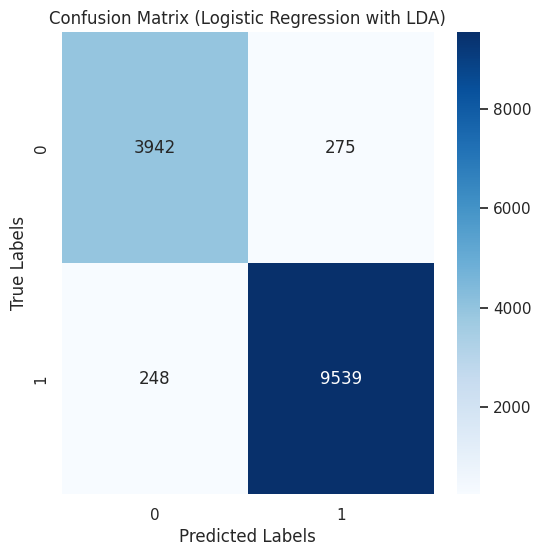

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (Logistic Regression with LDA)')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

Logistic Regression with PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42)
pca = PCA(n_components=20)
start_time_pca = time.time()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
pca_time = time.time() - start_time_pca
start_time_logistic = time.time()
logistic_model = LogisticRegression()
logistic_model.fit(X_train_pca, y_train)
logistic_time = time.time() - start_time_logistic
y_pred = logistic_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression on PCA data Accuracy: {accuracy}")
print(f"Logistic Regression computation time: {logistic_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression on PCA data Accuracy: 0.9798628963153385
Logistic Regression computation time: 0.2100 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4217
           1       0.98      0.99      0.99      9787

    accuracy                           0.98     14004
   macro avg       0.98      0.97      0.98     14004
weighted avg       0.98      0.98      0.98     14004



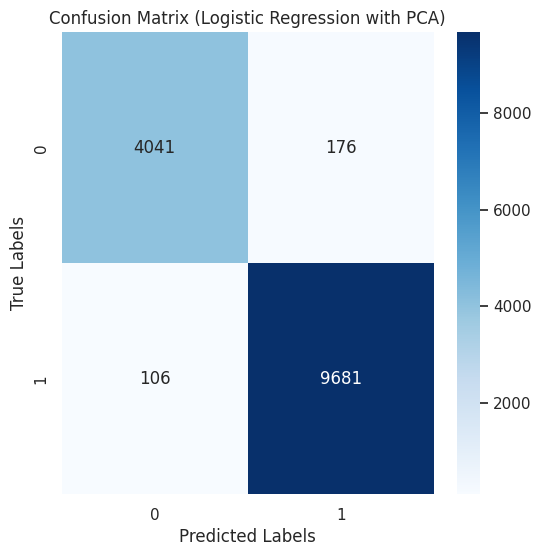

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (Logistic Regression with PCA)')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

Logistic Regression with Truncated SVD

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42)
svd= TruncatedSVD(n_components=20)
start_time_svd = time.time()
svd.fit(X_train)
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)
svd_time = time.time() - start_time_svd
start_time_logistic = time.time()
logistic_model = LogisticRegression()
logistic_model.fit(X_train_svd, y_train)
logistic_time = time.time() - start_time_logistic
y_pred = logistic_model.predict(X_test_svd)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression on Truncated SVD data Accuracy: {accuracy}")
print(f"Logistic Regression computation time: {logistic_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression on PCA data Accuracy: 0.9801485289917167
Logistic Regression computation time: 0.4459 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4217
           1       0.98      0.99      0.99      9787

    accuracy                           0.98     14004
   macro avg       0.98      0.97      0.98     14004
weighted avg       0.98      0.98      0.98     14004



Random Forest

In [ ]:
df_lda = df_scaled.select("scaled_features", target).toPandas()
X = np.array(df_lda['scaled_features'].tolist())
y = df_lda[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time_random_original = time.time()
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred_original = clf.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)
random_time_original = time.time() - start_time_random_original
print(f"Random Forest on Original Data Accuracy: {accuracy_original}")
print(f"Random Forest on Original Data time: {random_time_original:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred_original))

Random Forest on Original Data Accuracy: 0.989502999143102
Random Forest on Original Data time: 9.8674 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4217
           1       0.99      1.00      0.99      9787

    accuracy                           0.99     14004
   macro avg       0.99      0.99      0.99     14004
weighted avg       0.99      0.99      0.99     14004



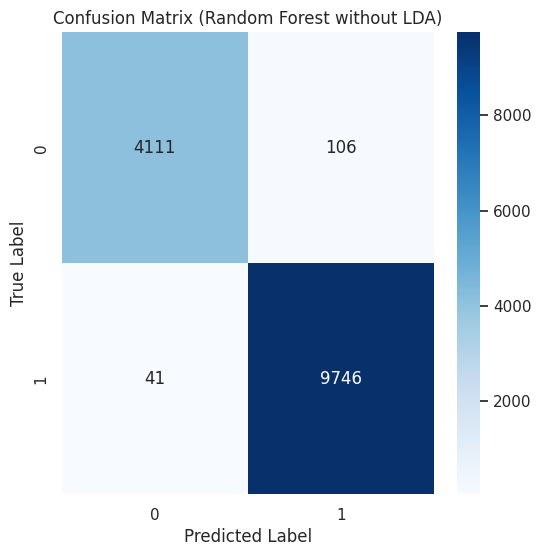

In [ ]:
cm_no_lda = confusion_matrix(y_test, y_pred_original)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm_no_lda, annot=True,fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix (Random Forest without LDA)')
plt.show()

Grid Search Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10],
    'min_samples_split': [2, 5, 10],
}
clf = RandomForestClassifier(random_state=42)
start_time_grid_search = time.time()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search_time = time.time() - start_time_grid_search
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Random Forest parameters:", best_params)
print(f"Grid Search for Random Forest time: {grid_search_time:.4f} seconds")
y_pred_original = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_original)
print(f"Random Forest Grid Search Accuracy: {accuracy}")

Best Random Forest parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
Grid Search for Random Forest time: 1635.9553 seconds
Random Forest Grid Search Accuracy: 0.9850756926592402


Accuracy metrics after grisearch

In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred_original)
precision_rf = precision_score(y_test, y_pred_original)
recall_rf = recall_score(y_test, y_pred_original)
f1_rf = f1_score(y_test, y_pred_original)
print("Random Forest after grisearch:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

Random Forest after grisearch:
Accuracy: 0.9851
Precision: 0.9832
Recall: 0.9957
F1-score: 0.9894


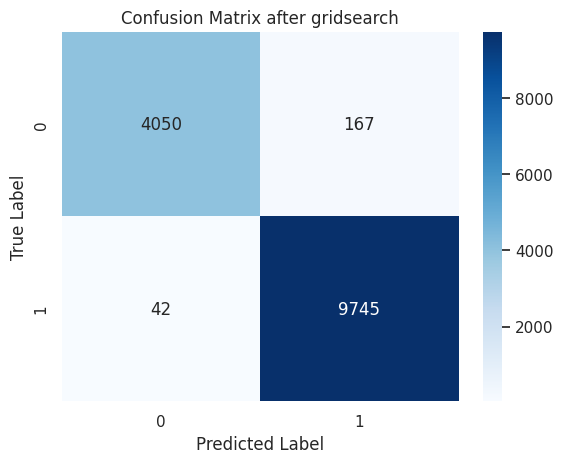

In [ ]:
cm = confusion_matrix(y_test, y_pred_original)
ax = sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix after gridsearch')
plt.show()

Random Forest trained on LDA data

In [ ]:
lda.fit(X_train, y_train)
lda_time = time.time() - start_time_lda
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
start_random_forest = time.time()
clf = RandomForestClassifier(n_estimators=300,max_depth=10, min_samples_split=5,random_state=42)
clf.fit(X_train_lda, y_train)
random_forest_time = time.time() - start_random_forest
y_pred = clf.predict(X_test_lda)
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest on LDA data Accuracy:", accuracy)
print(f"Random Forest computation time: {random_forest_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest on LDA data Accuracy: 0.9617252213653242
Random Forest computation time: 25.0022 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4217
           1       0.97      0.97      0.97      9787

    accuracy                           0.96     14004
   macro avg       0.95      0.95      0.95     14004
weighted avg       0.96      0.96      0.96     14004



Confusion Matrix(results with LDA)

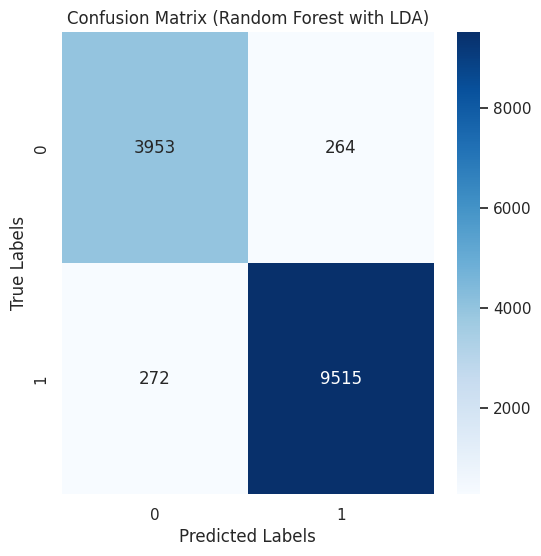

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (Random Forest with LDA)')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

Random Forest with PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42)
pca = PCA(n_components=20)
start_time_pca = time.time()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
pca_time = time.time() - start_time_pca
start_time_random = time.time()
clf.fit(X_train_pca, y_train)
random_time = time.time() - start_time_random
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest on PCA data Accuracy: {accuracy}")
print(f"Random Forest computation time: {logistic_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Random Forest on PCA data Accuracy: 0.9731505284204514
Random Forest computation time: 0.4459 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4217
           1       0.97      0.99      0.98      9787

    accuracy                           0.97     14004
   macro avg       0.97      0.96      0.97     14004
weighted avg       0.97      0.97      0.97     14004



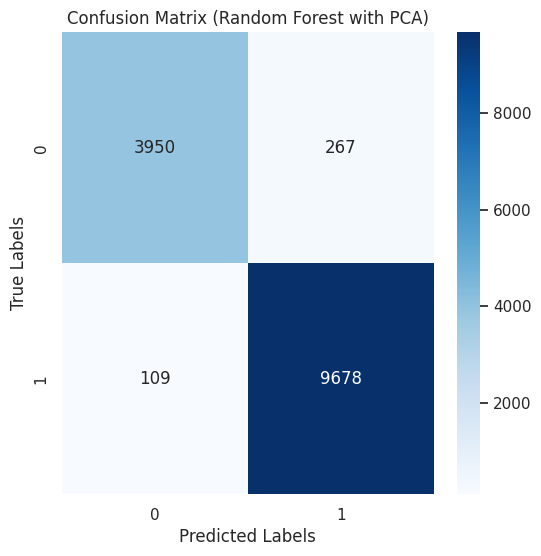

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (Random Forest with PCA)')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

Random Forest with Truncated SVD

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42)
svd= TruncatedSVD(n_components=20)
start_time_svd = time.time()
svd.fit(X_train)
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)
svd_time = time.time() - start_time_svd
start_time_random = time.time()
clf.fit(X_train_svd, y_train)
random_time = time.time() - start_time_random
y_pred = clf.predict(X_test_svd)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest on Truncated SVD data Accuracy: {accuracy}")
print(f"Random Forest computation time: {random_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Random Forest on Truncated SVD data Accuracy: 0.9716509568694659
Random Forest computation time: 72.5590 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      4217
           1       0.97      0.99      0.98      9787

    accuracy                           0.97     14004
   macro avg       0.97      0.96      0.97     14004
weighted avg       0.97      0.97      0.97     14004



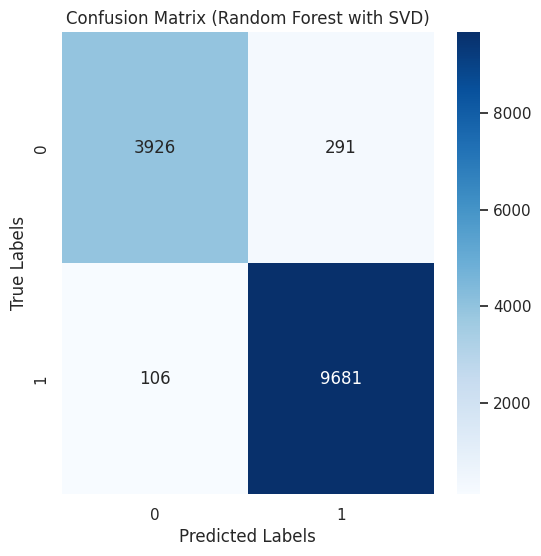

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (Random Forest with SVD)')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

GBM

In [ ]:
start_time_gbm = time.time()
gbm_original = GradientBoostingClassifier(random_state=42)
gbm_original.fit(X_train, y_train)
y_pred_original = gbm_original.predict(X_test)
gbm_time_original = time.time() - start_time_gbm
print("GBM:")
print("Accuracy:", accuracy_score(y_test, y_pred_original))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_original))
print("Classification Report:\n", classification_report(y_test, y_pred_original))
print(f"GBM data time: {gbm_time_original:.4f} seconds")

GBM:
Accuracy: 0.9897172236503856
Confusion Matrix:
 [[4115  102]
 [  42 9745]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      4217
           1       0.99      1.00      0.99      9787

    accuracy                           0.99     14004
   macro avg       0.99      0.99      0.99     14004
weighted avg       0.99      0.99      0.99     14004

GBM data time: 33.4447 seconds


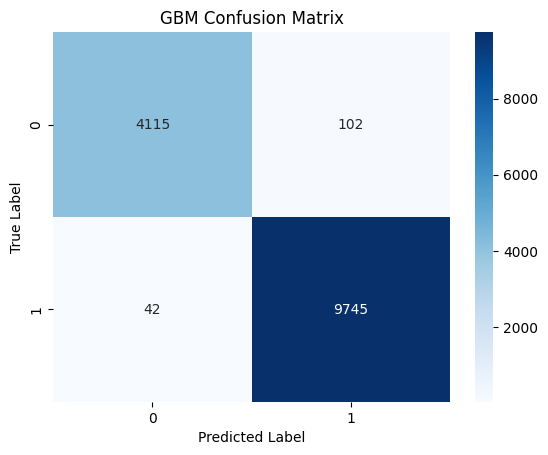

In [ ]:
cm = confusion_matrix(y_test, y_pred_original)
ax = sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('GBM Confusion Matrix')
plt.show()

Gridsearch GBM

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 8]
}


start_time_grid_search = time.time()

gbm = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(X_train_lda, y_train)
grid_search_time = time.time() - start_time_grid_search

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best GBM parameters with LDA:")
print(best_params)
print(f"Best GBM score with LDA: {best_score:.4f}")


best_gbm = grid_search.best_estimator_
y_pred = best_gbm.predict(X_test_lda)

print(f"Grid Search for Random Forest time: {grid_search_time:.4f} seconds")
accuracy = accuracy_score(y_test, y_pred)
print(f"GBM on LDA data (Grid Search) Accuracy: {accuracy}")


Accuracy metrics after gridsearch

In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
print("GBM with LDA after grisearch:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

Confusion Matrix GBM after Gridsearch

In [ ]:
cm_grid = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm_grid, annot=True, cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix (GBM with LDA after GridSearch)')
plt.show()

GBM with LDA

In [ ]:
start_time_lda = time.time()
lda.fit(X_train, y_train)
lda_time = time.time() - start_time_lda
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
start_time_gbm = time.time()
gbm_original.fit(X_train_lda, y_train)
gbm_time = time.time() - start_time_gbm
y_pred = gbm_original.predict(X_test_lda)
accuracy = accuracy_score(y_test, y_pred)
print(f"GBM on LDA data Accuracy: {accuracy}")
print(f"GBM computation time: {gbm_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))

GBM on LDA data Accuracy: 0.9607255069980005
GBM computation time: 11.0976 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4217
           1       0.97      0.97      0.97      9787

    accuracy                           0.96     14004
   macro avg       0.95      0.95      0.95     14004
weighted avg       0.96      0.96      0.96     14004



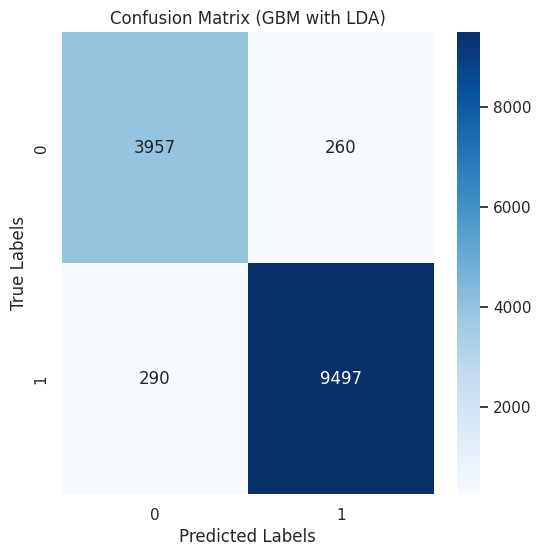

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (GBM with LDA)')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

GBM with PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42)
pca = PCA(n_components=20)
start_time_pca = time.time()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
pca_time = time.time() - start_time_pca
start_time_gbm = time.time()
gbm_original.fit(X_train_pca, y_train)
random_time = time.time() - start_time_gbm
y_pred = gbm_original.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"GBM on PCA data Accuracy: {accuracy}")
print(f"GBM computation time: {gbm_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))

GBM on PCA data Accuracy: 0.974150242787775
GBM computation time: 11.0976 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4217
           1       0.98      0.99      0.98      9787

    accuracy                           0.97     14004
   macro avg       0.97      0.97      0.97     14004
weighted avg       0.97      0.97      0.97     14004



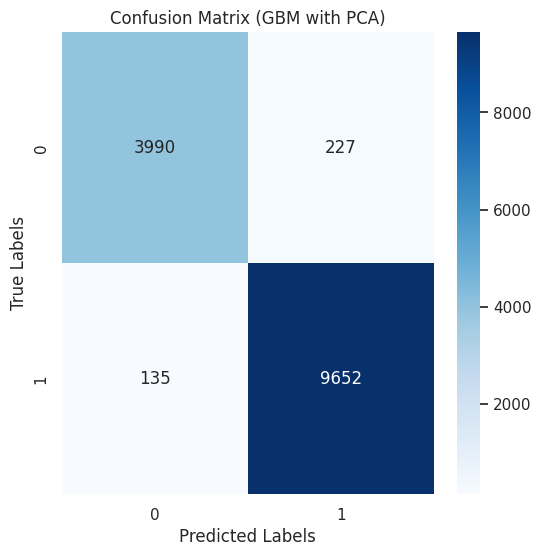

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (GBM with PCA)')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

GBM with Truncated SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42)
svd= TruncatedSVD(n_components=20)
start_time_svd = time.time()
svd.fit(X_train)
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)
svd_time = time.time() - start_time_svd
start_time_gbm = time.time()
gbm_original.fit(X_train_svd, y_train)
random_time = time.time() - start_time_gbm
y_pred = gbm_original.predict(X_test_svd)
accuracy = accuracy_score(y_test, y_pred)
print(f"GBM on Truncated SVD data Accuracy: {accuracy}")
print(f"GBM computation time: {random_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))


GBM on Truncated SVD data Accuracy: 0.9727934875749786
GBM computation time: 65.7581 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4217
           1       0.98      0.99      0.98      9787

    accuracy                           0.97     14004
   macro avg       0.97      0.96      0.97     14004
weighted avg       0.97      0.97      0.97     14004



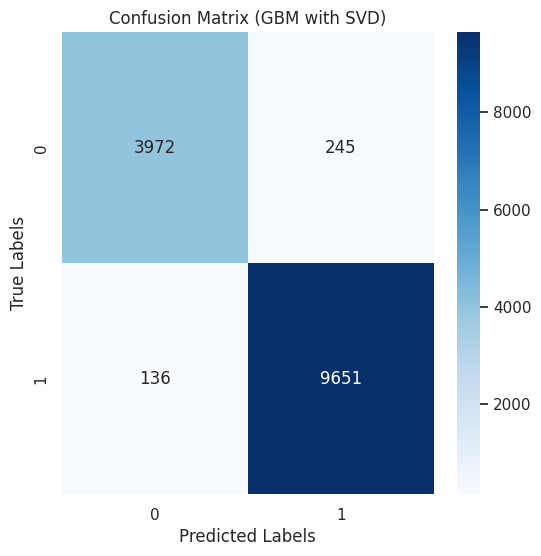

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (GBM with SVD)')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

SVM

In [ ]:
start_time_svm = time.time()
svm_original = SVC(kernel='linear', random_state=42)
svm_original.fit(X_train, y_train)
y_pred_original = svm_original.predict(X_test)
svm_time_original = time.time() - start_time_svm
print("SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_original))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_original))
print("Classification Report:\n", classification_report(y_test, y_pred_original))
print(f"SVM data time: {svm_time_original:.4f} seconds")

SVM
Accuracy: 0.9836475292773493
Confusion Matrix:
 [[4071  146]
 [  83 9704]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      4217
           1       0.99      0.99      0.99      9787

    accuracy                           0.98     14004
   macro avg       0.98      0.98      0.98     14004
weighted avg       0.98      0.98      0.98     14004

SVM data time: 53.0161 seconds


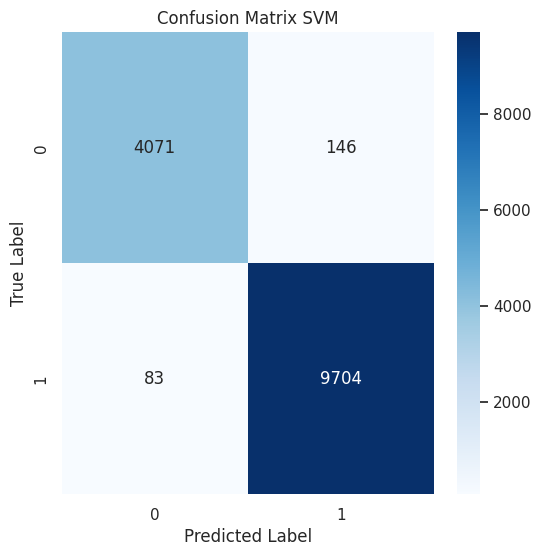

In [ ]:
cm_original = confusion_matrix(y_test, y_pred_original)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm_original, annot=True,fmt='d',cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix SVM')
plt.show()

SVM with LDA

In [ ]:
start_time_svm = time.time()

svm_lda = SVC(kernel='linear', random_state=42)
svm_lda.fit(X_train_lda, y_train)
y_pred_lda = svm_lda.predict(X_test_lda)
svm_time_lda = time.time() - start_time_svm
print("SVM with LDA:")
print("Accuracy:", accuracy_score(y_test, y_pred_lda))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lda))
print("Classification Report:\n", classification_report(y_test, y_pred_lda))
print(f"SVM data time: {svm_time_lda:.4f} seconds")

SVM with LDA:
Accuracy: 0.9616538131962297
Confusion Matrix:
 [[3952  265]
 [ 272 9515]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      4217
           1       0.97      0.97      0.97      9787

    accuracy                           0.96     14004
   macro avg       0.95      0.95      0.95     14004
weighted avg       0.96      0.96      0.96     14004

SVM data time: 83.5354 seconds


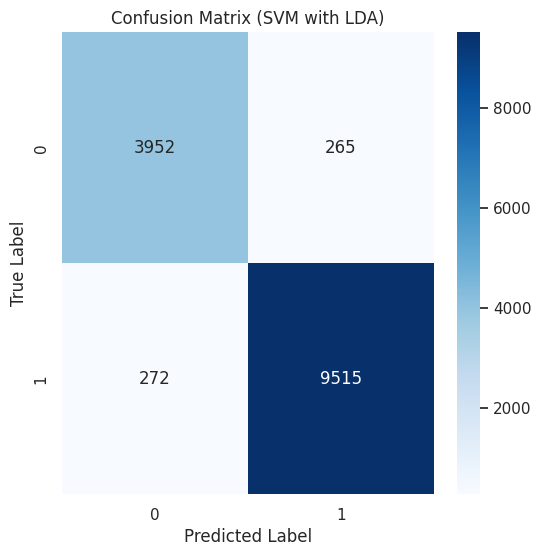

In [ ]:
cm_lda = confusion_matrix(y_test, y_pred_lda)
# Confusion Matrix for LDA
plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm_lda, annot=True,fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix (SVM with LDA)')
plt.show()

SVM with PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42)
pca = PCA(n_components=20)
start_time_pca = time.time()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
pca_time = time.time() - start_time_pca
start_time_svm = time.time()
svm_original.fit(X_train_pca, y_train)
svm_time = time.time() - start_time_svm
y_pred = svm_original.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM on PCA data Accuracy: {accuracy}")
print(f"SVM computation time: {svm_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"SVM on PCA data Accuracy: {accuracy}")
print(f"SVM computation time: {svm_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVM on PCA data Accuracy: 0.980719794344473
SVM computation time: 20.4366 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4217
           1       0.98      0.99      0.99      9787

    accuracy                           0.98     14004
   macro avg       0.98      0.98      0.98     14004
weighted avg       0.98      0.98      0.98     14004



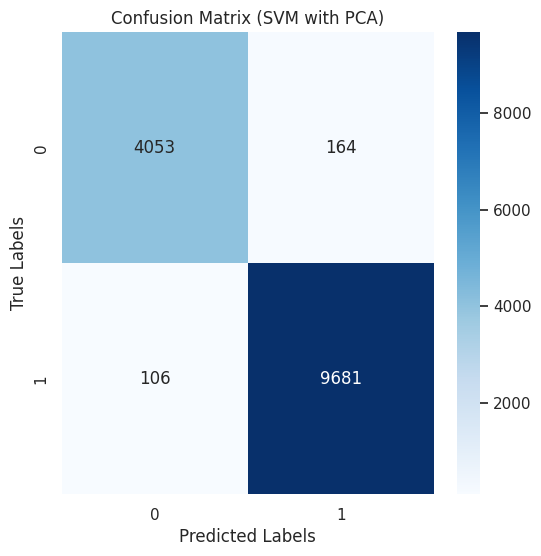

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (SVM with PCA)')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

GBM with Truncated SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42)
svd= TruncatedSVD(n_components=20)
start_time_svd = time.time()
svd.fit(X_train)
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)
svd_time = time.time() - start_time_svd
start_time_svm = time.time()
svm_original.fit(X_train_svd, y_train)
svm_time = time.time() - start_time_svm
y_pred = svm_original.predict(X_test_svd)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM on Truncated SVD data Accuracy: {accuracy}")
print(f"SVM computation time: {svm_time:.4f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))


SVM on Truncated SVD data Accuracy: 0.9806483861753784
SVM computation time: 18.5957 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4217
           1       0.98      0.99      0.99      9787

    accuracy                           0.98     14004
   macro avg       0.98      0.97      0.98     14004
weighted avg       0.98      0.98      0.98     14004



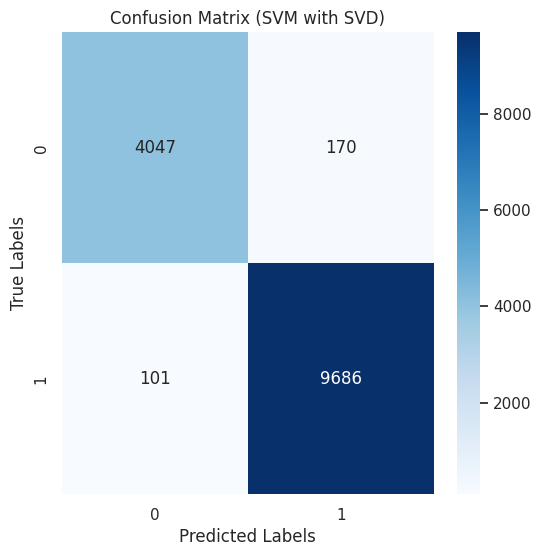

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (SVM with SVD)')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()